# Word Representations

- Static: each word meant only one thing
- Contextual: each word can mean different things depending on context

Options (Traditional NLP): 
1. One-hot-vectors: they are orthogonal, this is a very inefficient way to encode information (does not scale well with increaese in vocabulary)
2. SVD decomposition on Count/Co-Occurance matrix

### SVD Decomposition on Co-Occurance Matrix

Word embeddings map words to vectors, capturing semantic relationships through co-occurrence statistics and dimensionality reduction.

- Preprocessing: Lowercase, remove punctuation, tokenize, lemmatize. Optional: Remove stopwords.
- Vocabulary: Keep words with frequency ≥ $min\_freq$. Assign indices: $word \rightarrow idx$. Vocabulary size: $|V|$.
- Co-occurrence Matrix: Shape $|V| \times |V|$. Count co-occurrences within window $w$. Weight by inverse distance:  
  $$
  \text{weight} = \frac{1}{\text{distance}}
  $$  
  Log-scale: $M = \log(1 + M)$.
- Dimensionality Reduction: SVD: $M \approx U \Sigma V^T$. Truncate to $k$ dimensions:  
  $$
  \text{embeddings} = U_k \cdot \Sigma_k^{1/2}, \quad \text{shape } |V| \times k
  $$
- Visualization: t-SNE: Reduce to 2D. Heatmaps: Show top $n$ word relationships.
- Nearest Neighbors: Cosine similarity:  
  $$
  \text{sim}(u, v) = \frac{u \cdot v}{\|u\| \|v\|}
  $$  
  Find top $n$ neighbors.

Loading corpus...
Corpus loaded. Preprocessing...
Building vocabulary...
Vocabulary size: 988
Building co-occurrence matrix...
Visualizing co-occurrence matrix...


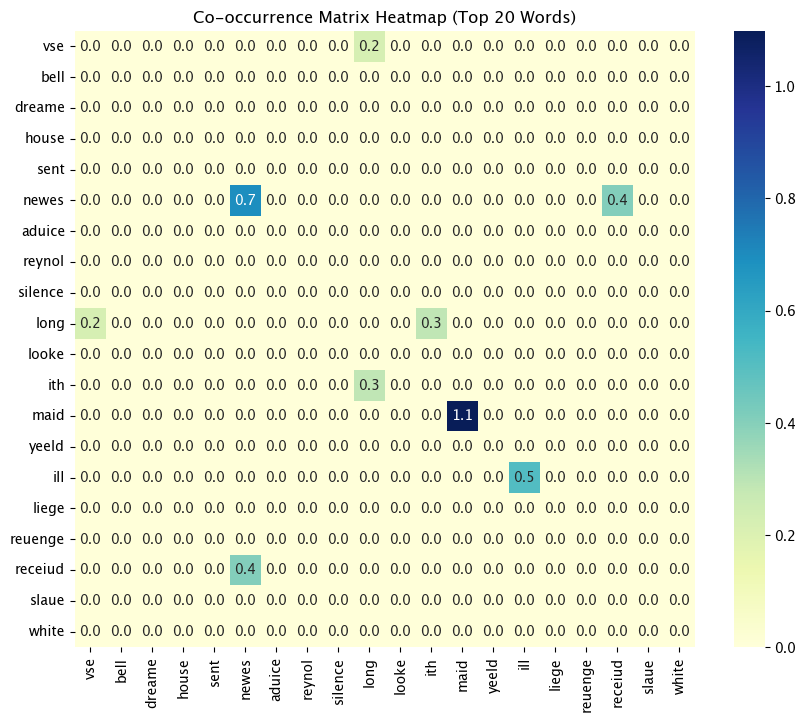

Reducing dimensions...
Visualizing embeddings with t-SNE...


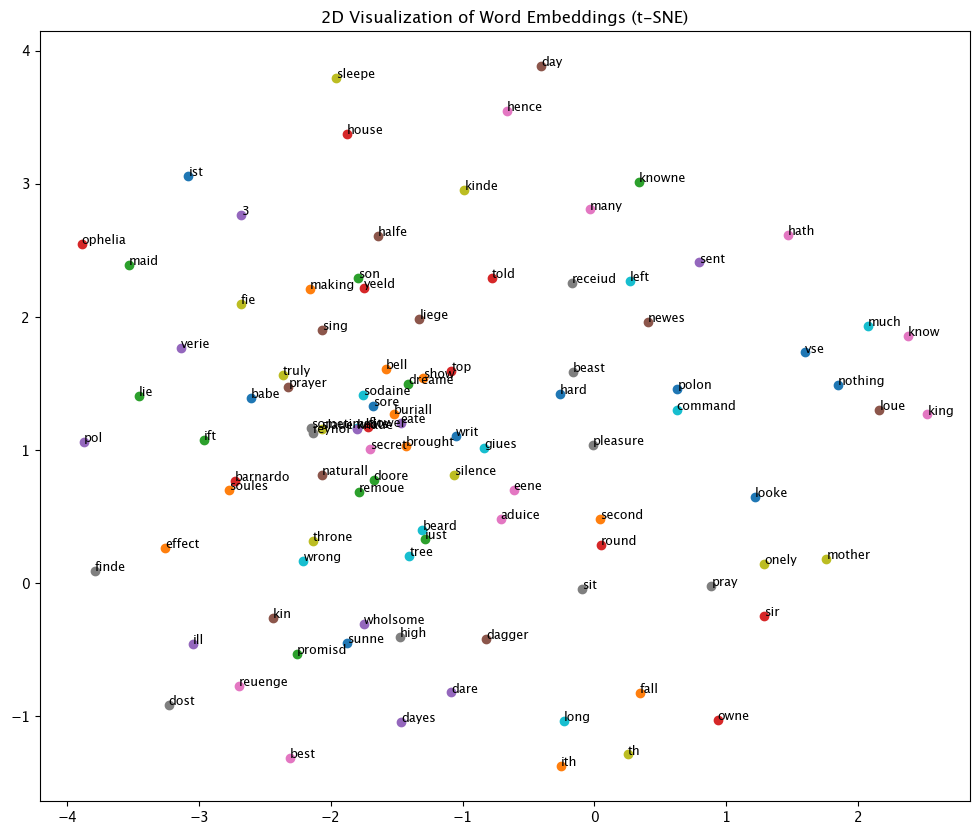

Finding nearest neighbors...
Nearest neighbors of 'king': ['good', 'go', 'lord', 'haue', 'ham']


In [20]:
import numpy as np
from collections import defaultdict
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, gutenberg
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import string

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocess text with lemmatization
def preprocess(text, remove_stopwords=True):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Build vocabulary
def build_vocab(corpus, min_freq=5):
    word_freq = defaultdict(int)
    for sentence in corpus:
        for word in sentence:
            word_freq[word] += 1
    vocab = {word for word, freq in word_freq.items() if freq >= min_freq}
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    index_to_word = {idx: word for word, idx in word_to_index.items()}
    return word_to_index, index_to_word

# Build co-occurrence matrix with dynamic window weighting
def build_co_matrix(corpus, word_to_index, window_size=5):
    vocab_size = len(word_to_index)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    for sentence in corpus:
        for i, target in enumerate(sentence):
            if target not in word_to_index:
                continue
            target_idx = word_to_index[target]
            start, end = max(0, i - window_size), min(len(sentence), i + window_size + 1)
            for j in range(start, end):
                if j == i:
                    continue
                context = sentence[j]
                if context in word_to_index:
                    # Weight by inverse distance
                    distance = abs(i - j)
                    weight = 1.0 / distance if distance > 0 else 1.0
                    co_matrix[target_idx][word_to_index[context]] += weight
    return np.log(1 + co_matrix)

# Reduce dimensions using SVD
def reduce_dims(matrix, k=100):
    k = min(k, matrix.shape[1])
    return TruncatedSVD(n_components=k, random_state=42).fit_transform(matrix)

# Visualize embeddings with t-SNE
def visualize_tsne(embeddings, index_to_word, num_words=100):
    perplexity = min(30, num_words - 1)
    embeddings_2d = TSNE(n_components=2, perplexity=perplexity, random_state=42).fit_transform(embeddings[:num_words])
    plt.figure(figsize=(12, 10))
    for i, (x, y) in enumerate(embeddings_2d):
        plt.scatter(x, y)
        plt.text(x, y, index_to_word[i], fontsize=9)
    plt.title("2D Visualization of Word Embeddings (t-SNE)")
    plt.show()

# Visualize co-occurrence matrix as a heatmap
def visualize_heatmap(matrix, index_to_word, num_words=20):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix[:num_words, :num_words], annot=True, fmt=".1f", cmap="YlGnBu",
                xticklabels=[index_to_word[i] for i in range(num_words)],
                yticklabels=[index_to_word[i] for i in range(num_words)])
    plt.title("Co-occurrence Matrix Heatmap (Top 20 Words)")
    plt.show()

# Find nearest neighbors
def nearest_neighbors(word, embeddings, word_to_index, index_to_word, top_n=5):
    if word not in word_to_index:
        print(f"Word '{word}' not in vocabulary.")
        return
    word_idx = word_to_index[word]
    word_vec = embeddings[word_idx]
    sims = np.dot(embeddings, word_vec) / (np.linalg.norm(embeddings, axis=1) * np.linalg.norm(word_vec))
    nearest = np.argsort(sims)[-top_n-1:-1][::-1]
    print(f"Nearest neighbors of '{word}': {[index_to_word[idx] for idx in nearest]}")

# Main pipeline
def main():
    # Load a larger corpus (e.g., Gutenberg dataset)
    print("Loading corpus...")
    corpus = gutenberg.raw("shakespeare-hamlet.txt") + gutenberg.raw("shakespeare-macbeth.txt")  # Use multiple texts
    print("Corpus loaded. Preprocessing...")

    # Preprocess corpus
    sentences = sent_tokenize(corpus)
    preprocessed = [preprocess(sentence) for sentence in sentences]

    # Build vocabulary and co-occurrence matrix
    print("Building vocabulary...")
    word_to_index, index_to_word = build_vocab(preprocessed, min_freq=5)
    print(f"Vocabulary size: {len(word_to_index)}")

    print("Building co-occurrence matrix...")
    co_matrix = build_co_matrix(preprocessed, word_to_index, window_size=5)

    # Visualize co-occurrence matrix as a heatmap
    print("Visualizing co-occurrence matrix...")
    visualize_heatmap(co_matrix, index_to_word, num_words=20)

    # Reduce dimensions and visualize with t-SNE
    print("Reducing dimensions...")
    embeddings = reduce_dims(co_matrix, k=100)
    print("Visualizing embeddings with t-SNE...")
    visualize_tsne(embeddings, index_to_word, num_words=100)

    # Find nearest neighbors
    print("Finding nearest neighbors...")
    nearest_neighbors("king", embeddings, word_to_index, index_to_word, top_n=5)

if __name__ == "__main__":
    main()

### Word2Vec with Negative Sampling

Neural word embeddings learn distributed representations by predicting word contexts through shallow neural networks.

- Architecture: Skip-gram model:  
  P(context|center) = σ(v_center · v_context)  
  Dual embeddings: v_word (center), u_word (context)

- Negative Sampling: Approximate softmax via noise contrast:  
  L = -logσ(v_c · u_w) - Σ_{k=1}^K logσ(-v_c · u_nk)  
  where n_k ∼ P(w)^{3/4} (subsampled unigram distribution)

- Training:  
  Window size w: Typically 2-10  
  Embedding dim d: 100-300  
  Negatives per sample k: 5-20  
  Learning rate: 0.001-0.025 (annealed)

- Optimization:  
  ∂L/∂v_c = (σ(v_c · u_w) - 1)u_w + Σ_{k=1}^K σ(v_c · u_nk)u_nk

- Visualization:  
  t-SNE/PCA on {v_w}  
  Analogies: v_king - v_man + v_woman ≈ v_queen

- Efficiency:  
  Complexity: O(|V| + k) vs O(|V|) for softmax  
  GPU-accelerated via batched outer products

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import re
from collections import Counter
import nltk
from nltk.corpus import brown

# Configuration
EMBED_DIM = 100
BATCH_SIZE = 1024
NEGATIVE_SAMPLES = 5
WINDOW_SIZE = 3
EPOCHS = 50
MIN_COUNT = 20
SUBSAMPLE = 0.5  # Speed up by using 50% of corpus

nltk.download('brown')

class BrownDataset(Dataset):
    def __init__(self):
        self.text = self.preprocess_text()
        self.vocab, self.word2idx, self.idx2word = self.build_vocab()
        self.pairs = self.generate_pairs()
        
    def preprocess_text(self):
        words = brown.words()[:int(len(brown.words())*SUBSAMPLE)]
        return [re.sub(r'[^a-z0-9]', '', w.lower()) for w in words if w.isalpha()]
    
    def build_vocab(self):
        counts = Counter(self.text)
        vocab = [w for w, c in counts.items() if c >= MIN_COUNT]
        return vocab, {w:i for i,w in enumerate(vocab)}, {i:w for i,w in enumerate(vocab)}
    
    def generate_pairs(self):
        pairs = []
        for i in range(WINDOW_SIZE, len(self.text)-WINDOW_SIZE):
            center_word = self.text[i]
            if center_word not in self.word2idx: continue
            context_words = [self.text[j] for j in range(i-WINDOW_SIZE, i+WINDOW_SIZE+1) 
                           if j != i and self.text[j] in self.word2idx]
            pairs.extend([(self.word2idx[center_word], self.word2idx[w]) for w in context_words])
        return pairs
    
    def __len__(self): return len(self.pairs)
    
    def __getitem__(self, idx):
        center, context = self.pairs[idx]
        negs = np.random.choice(len(self.vocab), NEGATIVE_SAMPLES)
        return torch.LongTensor([center]), torch.LongTensor([context]), torch.LongTensor(negs)

class SkipGram(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.in_emb = nn.Embedding(vocab_size, EMBED_DIM)
        self.out_emb = nn.Embedding(vocab_size, EMBED_DIM)
        
    def forward(self, center, context, negs):
        center_emb = self.in_emb(center)
        context_emb = self.out_emb(context)
        neg_emb = self.out_emb(negs)
        
        pos = torch.sum(center_emb * context_emb, dim=1)
        neg = torch.sum(center_emb.unsqueeze(1) * neg_emb, dim=2)
        return -torch.mean(torch.log(torch.sigmoid(pos)) + torch.log(torch.sigmoid(-neg)).mean(dim=1))

def visualize(model, dataset):
    embeddings = model.in_emb.weight.detach().numpy()
    tsne = TSNE(n_components=2).fit_transform(embeddings)
    
    plt.figure(figsize=(12,10))
    for i in range(50):  # Plot first 50 words
        plt.scatter(tsne[i,0], tsne[i,1])
        plt.annotate(dataset.idx2word[i], (tsne[i,0], tsne[i,1]), alpha=0.7)
    plt.show()

def print_closest_words(model, dataset, query_words, top_k=5):
    embeddings = model.in_emb.weight.data
    norms = torch.norm(embeddings, dim=1, keepdim=True)
    normalized = embeddings / norms
    
    for word in query_words:
        if word not in dataset.word2idx:
            print(f"'{word}' not in vocabulary")
            continue
            
        idx = dataset.word2idx[word]
        similarity = torch.mm(normalized, normalized[idx].unsqueeze(1)).squeeze()
        _, indices = torch.topk(similarity, top_k+1)
        
        neighbors = [dataset.idx2word[i.item()] for i in indices[1:]]  # Skip self
        print(f"{word}: {', '.join(neighbors)}")

def train():
    dataset = BrownDataset()
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model = SkipGram(len(dataset.vocab))
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print(f"Training on {len(dataset)} pairs | Vocab size: {len(dataset.vocab)}")
    
    for epoch in range(EPOCHS):
        total_loss = 0
        for centers, contexts, negs in loader:
            optimizer.zero_grad()
            loss = model(centers.squeeze(), contexts.squeeze(), negs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss {total_loss/len(loader):.4f}")
    
    visualize(model, dataset)
    print("\nNearest neighbors:")
    print_closest_words(model, dataset, ['government', 'city', 'year', 'war', 'president'])

if __name__ == "__main__":
    train()

[nltk_data] Downloading package brown to /Users/pranjal/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Training on 1999539 pairs | Vocab size: 2843
Epoch 1: Loss 5.1141
Epoch 2: Loss 2.6631
Epoch 3: Loss 1.8073
Epoch 4: Loss 1.4352


KeyboardInterrupt: 

In [31]:
pip install gensim

  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 65.6 MB/s eta 0:00:00a 0:00:01
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 65.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
Note: you may need to restart the kernel to use updated packages.
